### Analysis and plotting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.dates import date2num
import os
import datetime as dt
import xarray as xr
from scipy import stats
import re
from scipy.signal import argrelextrema, argrelmax
import rasterio as rio

%matplotlib inline

In [2]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

---
## Open data files

---
---
#### Open our merged GOES-CUES dataset

In [3]:
cues_ds = pd.read_pickle('goes-cues_2017-2020.pkl')
cues_ds = cues_ds.to_xarray()

In [4]:
#df = pd.read_pickle('goes-cues-2017-2020-6hr.pkl')


Load MODIS observations of the CUES site

In [5]:
#modis_1 = pd.read_pickle('./MODIS_data/cues_2017_1-59.pkl')
#modis_2 = pd.read_pickle('./MODIS_data/cues_2017_60-120.pkl')
#
## Concatenate the two MODIS time series together
#modis = pd.concat([modis_1, modis_2], ignore_index=True)

When do we have ASTER observations of this site?

In [27]:
# Find all our ASTER files for the CUES site
#directory1 = r'//j-lundquist-3.ce.washington.edu/storage/spestana/ASTER/AST_L1T/geotiff/T/T_Tuolumne-and-CUES/T_Tuolumne_only/'
#directory2 = r'//j-lundquist-3.ce.washington.edu/storage/spestana/ASTER/AST_L1T/geotiff/T/T_Tuolumne-and-CUES/T_both/'
#aster_files = getListOfFiles(directory1) + getListOfFiles(directory2)

directory = r"//j-lundquist-3.ce.washington.edu/storage/spestana/ASTER/AST_L1T/geotiff/T/T_band14_Tuolumne-and-CUES"
aster_files = getListOfFiles(directory)

## Parse the date and time from ASTER filenames
aster_datetimes = []
for fpath in aster_files:
    #fn = re.split('\/+|\\+',fpath)[-1] # re method
    fn = fpath.split('\\')[-1] # non-re method
    MM = fn.split('_')[2][3:5]
    DD = fn.split('_')[2][5:7]
    YYYY = fn.split('_')[2][7:11]
    hh = fn.split('_')[2][11:13]
    mm = fn.split('_')[2][13:15]
    ss = fn.split('_')[2][15:17]
    aster_datetimes.append(pd.Timestamp('{}-{}-{} {}:{}:{}'.format(YYYY, MM, DD, hh, mm, ss)) - pd.Timedelta(hours=7))

aster = pd.DataFrame({'datetime': aster_datetimes, 'filepath': aster_files})
aster.sort_values('datetime',inplace=True)
aster.reset_index(inplace=True, drop=True)

Set font sizes for plots

In [44]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [45]:
def plot1to1(_x, _y, x_label, y_label, startdate, enddate, point_color='k', heatmap_cmap=None):
    _x = _x.sel(datetime=slice(startdate, enddate))
    _y = _y.sel(datetime=slice(startdate, enddate))

    # Linear regression between x and y
    x, y, slope, intercept, r_value, p_value, std_err, rmse, mbe, mae, covar = quickstats(_x, _y)
    fit = slope*x + intercept
    # Compute some more stats between x and y:
    #print('r-squared = {}'.format(np.round(r_value**2,2)))

    
    plt.figure(figsize=(5.5,5.5))
    # Plot gridlines
    plt.grid(color='grey', linestyle=':', linewidth=1)
    # Plot points and best linear fit
    #plt.plot(x, fit, ':r', zorder=99)

    if heatmap_cmap == None:
        plt.plot(x,y,'.',color=point_color,markersize=5,alpha=0.5)
    else:
        # Create 2d histogram "heatmap"
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=75)
        extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        # Plot "heatmap"
        plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=heatmap_cmap)
        plt.colorbar(label='number of records')

    # Plot 1-to-1 line
    plt.plot([-30,30],[-30,30],':k')

    # Set axes limits
    plt.xlim([-30,30])
    plt.ylim([-30,30])

    # Set axes labels, plot title
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title('{} -- {}\n$RMSE$ = {}, mean bias = {}'.format(startdate,enddate,
                                                            np.round(rmse,2),
                                                           np.round(mbe,2)))
    plt.tight_layout()
    
    return None

def quickstats(_x,_y):
    # remove nan values from input _x and _y before linear regression
    df1 = pd.DataFrame({'x': _x})
    df1['y'] = _y
    df1 = df1.dropna()
    x = df1.x
    y = df1.y

    # Linear regression between x and y
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean(np.square(y - x)))
    
    # Mean Bias Error
    mbe = np.mean(y - x)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(y - x))
    
    # Covariance
    X = np.stack((x, y), axis=0)
    covar = np.cov(X)
    
    return x, y, slope, intercept, r_value, p_value, std_err, rmse, mbe, mae, covar

In [46]:
from datetime import timedelta, datetime

def datetimerange(start_date, end_date, n_hours):
    # https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python/1060330#1060330
    # for every hour in this date range
    for n in range(int ( (end_date - start_date).total_seconds() / 3600 )):
        # if we've moved n_hours
        if n % n_hours == 0:
            # return the start date + that many hours we've stepped forward
            yield start_date + timedelta(hours=n)

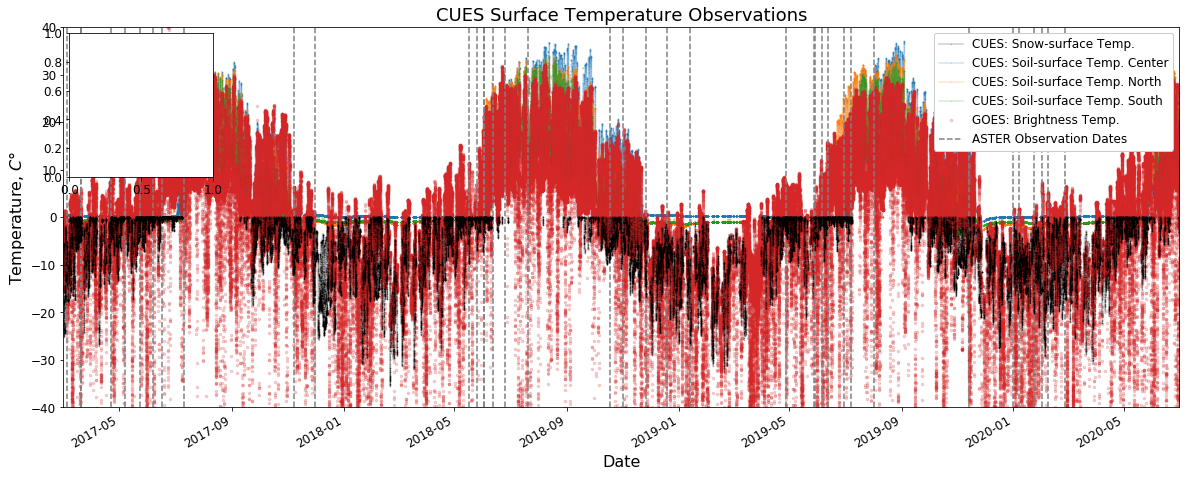

In [111]:
# Set start and end dates for time period we want to look at
startdate = cues_ds.datetime.min().values
enddate = cues_ds.datetime.max().values
#startdate = pd.Timestamp('2017-03-20')
#enddate = pd.Timestamp('2017-03-21')

alpha = 0.2
condition = cues_ds.cloud_flag==0

# Set up figure
fig, ax = plt.subplots(figsize=(20,7))

# Plot CUES snow surface temperature
cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].where(condition).plot(
    c='k', marker='.', ax=ax, markersize=1, linestyle='-', zorder=99, alpha=alpha)

# Plot CUES soil surface temperature
cues_ds['soil temperature @ 0cm; soil temp at 0cm  center; (degrees Celsius)'].where(condition).plot(ax=ax, linestyle='-', marker='.', markersize=1, alpha=alpha)
cues_ds['soil temp at 0cm  north; soil thermistor at 0cm  north; (deg C)'].where(condition).plot(ax=ax, linestyle='-', marker='.', markersize=1, alpha=alpha)
cues_ds['soil temp at 0cm  south; soil thermistor at 0cm  south; (deg C)'].where(condition).plot(ax=ax, linestyle='-', marker='.', markersize=1, alpha=alpha)

# Plot GOES brightness temperature
cues_ds.goes_tb_c.where(condition).plot(c='tab:red', linestyle='none', marker='.', markersize=5, ax=ax, alpha=alpha)

# Plot when we have ASTER observations of the CUES site
for aster_datetime in aster.datetime:
    plt.axvline(x=aster_datetime, color='grey', linestyle='--')

ax.set_xlim([startdate,enddate])
ax.set_ylim([-40,40])
ax.set_ylabel('Temperature, $C\degree$')
ax.set_xlabel('Date')

# Make legend
lines = [ax.lines[0], ax.lines[1], ax.lines[2], ax.lines[3], ax.lines[4], ax.lines[5]]
labels = ['CUES: Snow-surface Temp.', 
          'CUES: Soil-surface Temp. Center', 
          'CUES: Soil-surface Temp. North', 
          'CUES: Soil-surface Temp. South',
          'GOES: Brightness Temp.',
         'ASTER Observation Dates']
ax.legend(lines, labels, loc='upper right', facecolor='white', framealpha=1)

# Set title
plt.title('CUES Surface Temperature Observations');


inset_ax = inset_axes(ax,
                    width=2., # width : 1 inch
                    height=2., # height : 1 inch
                    loc=2)


# Save figure image
#plt.savefig('goes-cues-Mar2017-Jun2020.jpg',dip=300);

## For comparison with ASTER, looking at single days

#### Create 1-to-1 plots to take a look at the slope of the regression lines in more detail for days with ASTER observations

In [332]:
aster_subset = aster.loc[[0,5,10,15,20,25,31,35]]
aster_subset.reset_index(inplace=True)

In [337]:
aster_subset = aster

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


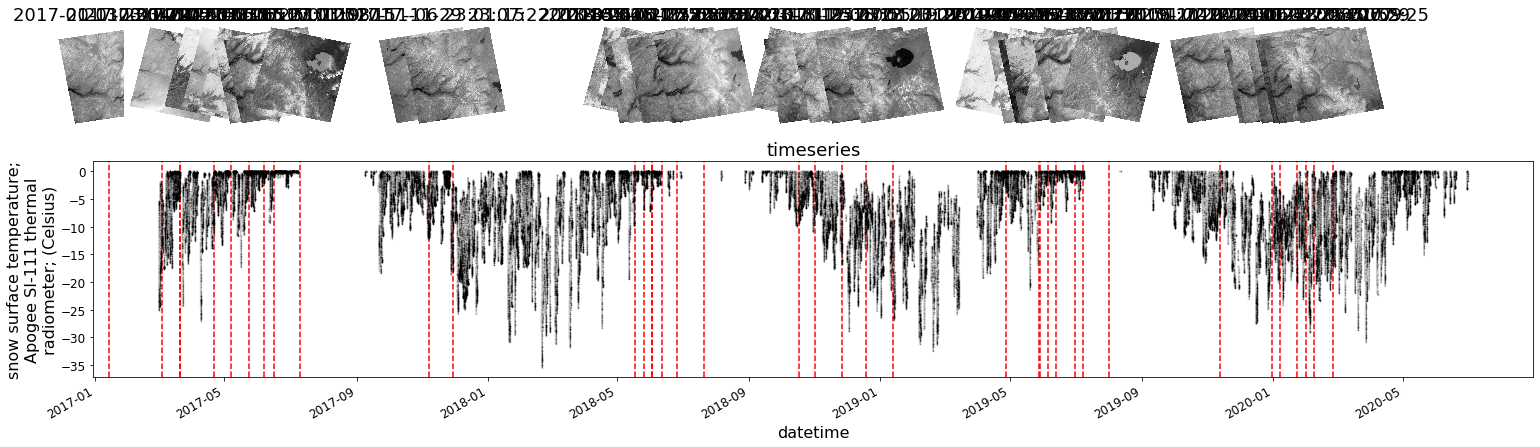

In [343]:
n_total = aster_subset.shape[0]

fig, ax = plt.subplots(figsize=(20,5))

# Plot CUES snow surface temperature
cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].where(condition).plot(
    c='k', marker='.', ax=ax, markersize=1, linestyle='-', zorder=99, alpha=alpha)
ax.set_position([0, 0, 1, 0.6])
ax.set_title('timeseries')



for n in range(n_total):

    # draw a vertical line at the ASTER observation date
    ax.axvline(aster_subset.datetime[n], c='r', linestyle='--')
    
    # Inset plot
    inset_plot_width = 0.25 + 1/n_total
    inset_plot_height = 0.25 + 1/n_total
    
    
    # transform from data coordinates (x=datetime64, y=temperature) into display coordinates (pixels)
    xdisplay, ydisplay = ax.transData.transform((date2num(aster_subset.datetime[n]),0))
    # create an inverse transform from display coordinates (pixels) into figure coordinates (fractions)
    inv = fig.transFigure.inverted()
    # apply the inverse transform
    inset_plot_xpos, _ = inv.transform((xdisplay, ydisplay))
    
    #inset_plot_xpos = np.linspace(0, 1-(1/n_total), n_total)[n] # x coordinate for evenly spaced images
    inset_plot_ypos = 0.7 # fixed y coordinate
    
    current_ax = fig.add_axes([inset_plot_xpos - (inset_plot_width/2), inset_plot_ypos, 
                               inset_plot_width, inset_plot_height], 
                              facecolor='k')
    current_ax.set_title('{}'.format(aster_subset.datetime[n]))
    current_ax.axis('off')
    
    fpath = os.path.normpath(aster_subset.filepath[n])
    with rio.open(fpath) as src:
        a = src.read(1)
        a = a.astype('float32')
        a[a==0] = np.nan
        current_ax.imshow(a, cmap='Greys')



In [331]:
aster

,datetime,filepath
0,2017-01-13 23:07:12,//j-lundquist-3.ce.washington.edu/storage/spes...
1,2017-03-04 11:51:03,//j-lundquist-3.ce.washington.edu/storage/spes...
2,2017-03-20 11:51:06,//j-lundquist-3.ce.washington.edu/storage/spes...
3,2017-03-20 11:51:06,//j-lundquist-3.ce.washington.edu/storage/spes...
4,2017-04-21 11:51:07,//j-lundquist-3.ce.washington.edu/storage/spes...
5,2017-05-07 11:51:10,//j-lundquist-3.ce.washington.edu/storage/spes...
6,2017-05-23 11:51:10,//j-lundquist-3.ce.washington.edu/storage/spes...
7,2017-06-06 23:07:19,//j-lundquist-3.ce.washington.edu/storage/spes...
8,2017-06-15 23:01:08,//j-lundquist-3.ce.washington.edu/storage/spes...
9,2017-07-10 11:51:15,//j-lundquist-3.ce.washington.edu/storage/spes...


2020-01-10 00:00:00
2020-01-10 06:00:00
2020-01-10 12:00:00
2020-01-10 18:00:00


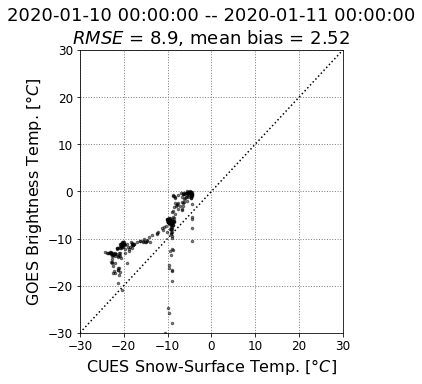

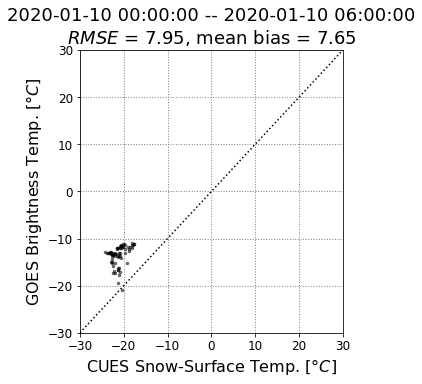

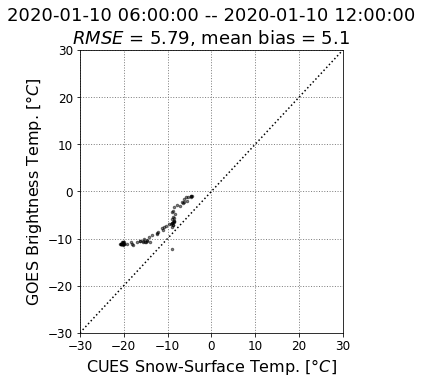

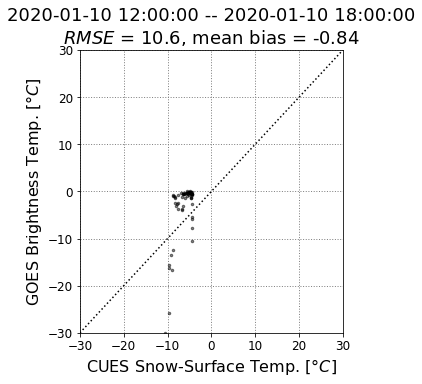

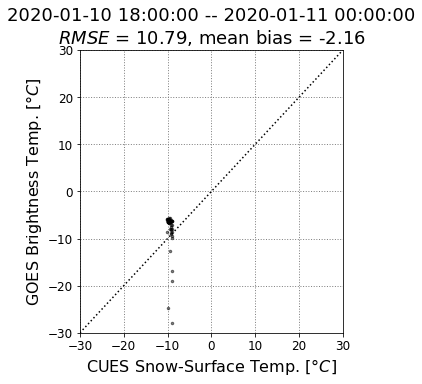

In [28]:
start_date = datetime(2020, 1, 10)
end_date = datetime(2020, 1, 11)
n_hours = 6

_x = cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].where(cues_ds.cloud_flag==0)
x_label = 'CUES Snow-Surface Temp. [$\degree C$]'

_y = cues_ds.goes_tb_c.where(cues_ds.cloud_flag==0)
y_label = 'GOES Brightness Temp. [$\degree C$]'

# plot whole day
plot1to1(_x, _y, x_label, y_label, start_date, end_date, point_color='k', heatmap_cmap=None)

for single_datetime in datetimerange(start_date, end_date, n_hours=n_hours):
    print(single_datetime.strftime("%Y-%m-%d %H:%M:%S"))

    startdate = single_datetime
    enddate = single_datetime + timedelta(hours=n_hours)
    
    plot1to1(_x, _y, x_label, y_label, startdate, enddate, point_color='k', heatmap_cmap=None)

In [29]:
#plt.figure(figsize=(8,8))
#plt.plot(df.mbe,df.rmse,'k.')
#plt.xlabel('Mean Bias')
#plt.ylabel('RMSE')
##plt.xlim(-40,40)
##plt.ylim(-1.5,1.5)
#plt.title('6-hr Mean Bias vs Daily RMSE\nwhen snow is present\nfrom {} to {}'.format(startdate,enddate))
#plt.tight_layout()

In [30]:
#binwidth = 2
#
#for year_month in df.groupby(df.index.to_period('M')).mean().index:
#    this_month = df.loc[df.index.to_period('M') == year_month]
#    
#    plt.figure(figsize=(4,4))
#    N, bins, _ = plt.hist(this_month.rmse,bins=range(0, 50+binwidth, binwidth))
#    plt.xlim(0,50)
#    plt.ylim(0,50)
#    plt.title('6-hr RMSE when snow is present\nfor {}'.format(year_month))
#    try:
#        maxima_indices = argrelmax(N, order=1)[0]
#        largest_mode = bins[:-1][N==N[maxima_indices].max()].mean()
#        plt.axvline(x=largest_mode+(binwidth/2),linestyle=':',color='k')
#    except (IndexError, ValueError):
#        pass
#    plt.xlabel('RMSE')
#    plt.ylabel('Number of 6-hour periods')
#    plt.tight_layout()